In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

features = pd.read_parquet("./outputs/features_ml/features_ml_clean.parquet")
labels   = pd.read_parquet("./outputs/samples/labels.parquet")

features["user_id"] = features["user_id"].astype(str)
labels["user_id"]   = labels["user_id"].astype(str)

features["anchor_time"] = pd.to_datetime(features["anchor_time"])
labels["anchor_time"]   = pd.to_datetime(labels["anchor_time"])

df = features.merge(
    labels[["user_id","anchor_time","label","split"]],
    on=["user_id","anchor_time"],
    how="inner",
    validate="one_to_one"
)

df["y_bin"] = (df["label"] == "m2").astype(int)

In [7]:
feature_cols = [c for c in df.columns if c not in ["user_id","anchor_time","label","split","y_bin"]]

X_train = df[df.split=="train"][feature_cols]
y_train = df[df.split=="train"]["y_bin"]

X_test  = df[df.split=="test"][feature_cols]
y_test  = df[df.split=="test"]["y_bin"]

In [8]:
logistic = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

hgb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    random_state=42
)

logistic.fit(X_train, y_train)
hgb.fit(X_train, y_train)

prob_log = logistic.predict_proba(X_test)[:,1]
prob_hgb = hgb.predict_proba(X_test)[:,1]

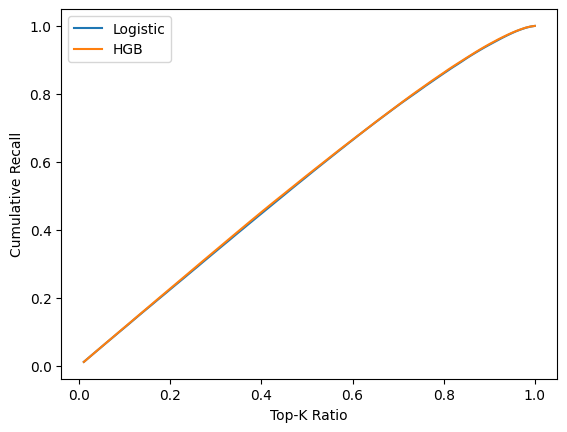

In [9]:
def cumulative_recall(y, p, steps=100):
    df = pd.DataFrame({"y":y,"p":p}).sort_values("p", ascending=False)
    total = df.y.sum()
    xs, ys = [], []
    for k in range(1, steps+1):
        r = k/steps
        ys.append(df.iloc[:int(len(df)*r)].y.sum()/total)
        xs.append(r)
    return xs, ys

x, r_log = cumulative_recall(y_test.values, prob_log)
_, r_hgb = cumulative_recall(y_test.values, prob_hgb)

plt.figure()
plt.plot(x, r_log, label="Logistic")
plt.plot(x, r_hgb, label="HGB")
plt.xlabel("Top-K Ratio")
plt.ylabel("Cumulative Recall")
plt.legend()
plt.show()

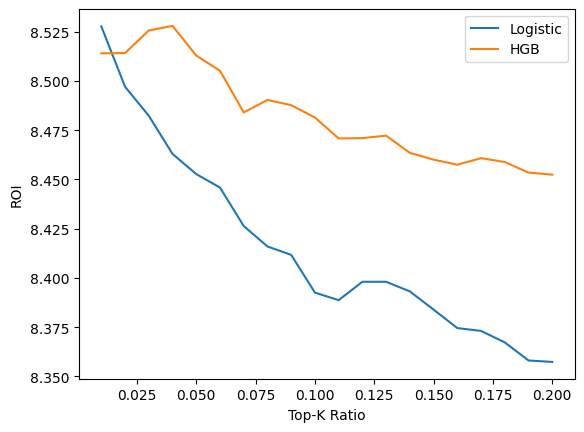

In [10]:
COST = 1
VALUE = 10

def roi_curve(y, p):
    df = pd.DataFrame({"y":y,"p":p}).sort_values("p", ascending=False)
    ratios = np.linspace(0.01, 0.2, 20)
    rois = []
    for r in ratios:
        k = int(len(df)*r)
        hit = df.iloc[:k].y.sum()
        rois.append((hit*VALUE - k*COST)/(k*COST))
    return ratios, rois

x, roi_log = roi_curve(y_test.values, prob_log)
_, roi_hgb = roi_curve(y_test.values, prob_hgb)

plt.figure()
plt.plot(x, roi_log, label="Logistic")
plt.plot(x, roi_hgb, label="HGB")
plt.xlabel("Top-K Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

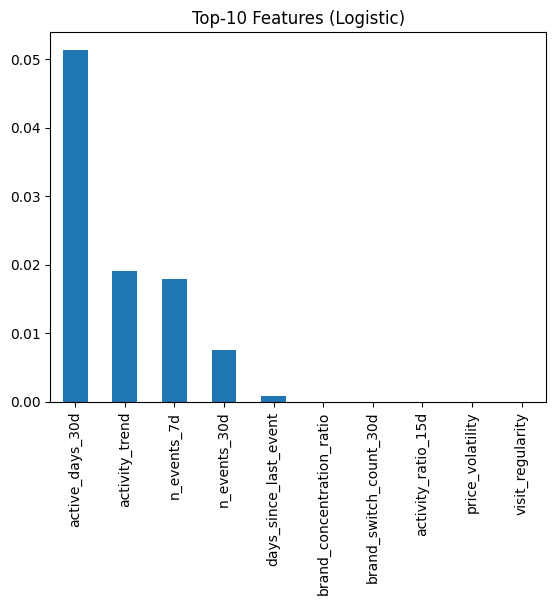

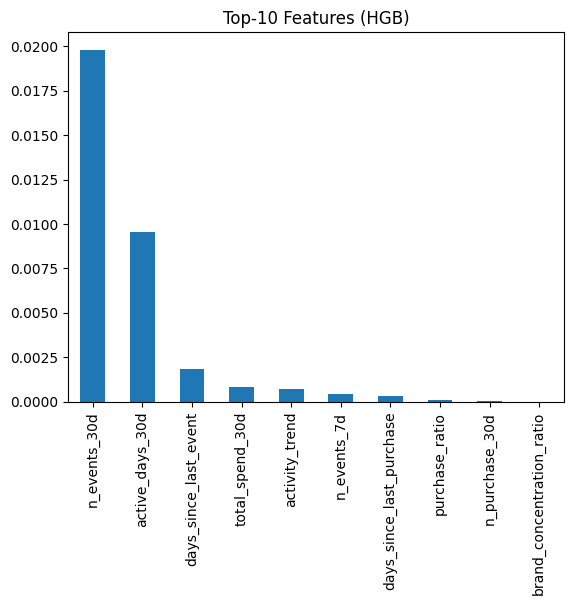

In [13]:
imp_log = permutation_importance(logistic, X_test, y_test, n_repeats=5, random_state=42)
imp_hgb = permutation_importance(hgb, X_test, y_test, n_repeats=5, random_state=42)

pd.Series(imp_log.importances_mean, index=X_test.columns)\
  .sort_values(ascending=False).head(10)\
  .plot(kind="bar", title="Top-10 Features (Logistic)")
plt.show()

pd.Series(imp_hgb.importances_mean, index=X_test.columns)\
  .sort_values(ascending=False).head(10)\
  .plot(kind="bar", title="Top-10 Features (HGB)")
plt.show()

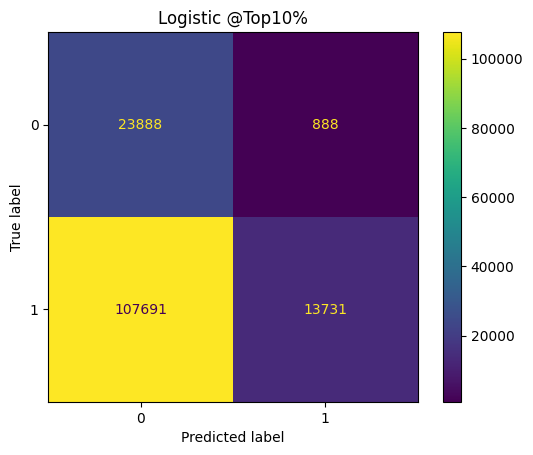

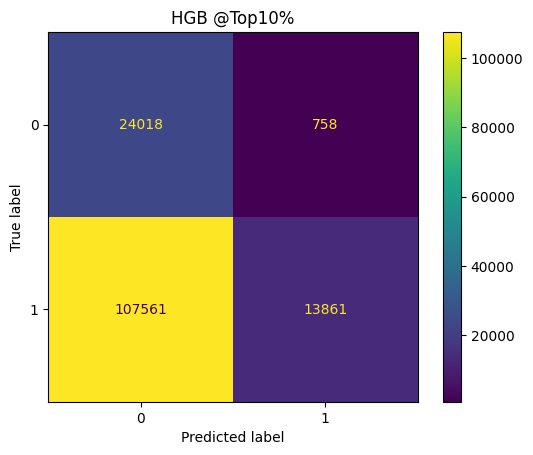

In [14]:
def cm_topk(y, p, k=0.1):
    df = pd.DataFrame({"y":y,"p":p}).sort_values("p", ascending=False)
    df["pred"] = 0
    df.iloc[:int(len(df)*k), df.columns.get_loc("pred")] = 1
    return confusion_matrix(df.y, df.pred)

ConfusionMatrixDisplay(cm_topk(y_test, prob_log)).plot()
plt.title("Logistic @Top10%")
plt.show()

ConfusionMatrixDisplay(cm_topk(y_test, prob_hgb)).plot()
plt.title("HGB @Top10%")
plt.show()

Accuracy: 0.8470909314764908
Error Rate: 0.15290906852350916


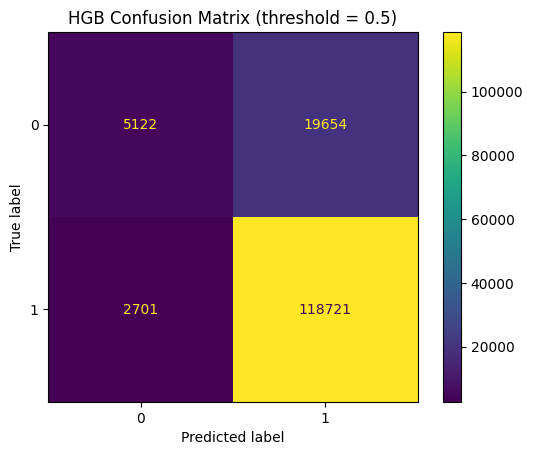

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# threshold = 0.5
y_pred_hgb = (prob_hgb >= 0.5).astype(int)

cm_full = confusion_matrix(y_test, y_pred_hgb)
acc = accuracy_score(y_test, y_pred_hgb)
error_rate = 1 - acc

print("Accuracy:", acc)
print("Error Rate:", error_rate)

ConfusionMatrixDisplay(cm_full).plot(values_format="d")  # 🔥 여기
plt.title("HGB Confusion Matrix (threshold = 0.5)")
plt.show()